In [2]:
import pandas as pd

from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('Step02_updated02.csv',sep = ',')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.shape

(717217, 22)

In [3]:
# Since all the features of logistic model should be numerical, we need to convert the categorical variables to dummy variables

# Extract the numeracial variables first
num_df = df[['visitNumber','totalshits','totalspageviews','totalssessionQualityDim','totalstimeOnSite','totalTransactionRevenue']]


In [4]:
# Extract the categorical variables 
dummy_df = df[['channelGrouping','deviceCategory','isMobile','Nbrowsers','Noperatingsystem','NtrafficSourcemedium',\
              'NtrafficSourcesource']]

In [5]:
# Convert the categorical variables to dummy variable
for i in dummy_df.columns:
     for elem in dummy_df[i].unique():
        dummy_df[str(elem)] = dummy_df[i] == elem


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
dummy_df = dummy_df[dummy_df.columns[7:]]

In [7]:
# Change the column names of dummy variables
dummy_df.columns = ['channelGrouping = Referral', 'channelGrouping = Direct','channelGrouping = Organic Search ',\
                'channelGrouping = Paid Search','channelGrouping = Display','channelGrouping = Social','channelGrouping = Affiliates',\
                'channelGrouping = (Other)','deviceCategory = desktop', 'deviceCategory = mobile','deviceCategory = tablet',\
                'isMobile = False','isMobile = True', 'Nbrowsers = Chrome','Nbrowsers = Safari','Nbrowsers = others',\
                 'Noperatingsystem = Android','Noperatingsystem = Macintosh','Noperatingsystem = iOS','Noperatingsystem = Windows',\
                'NtrafficSourcemedium =referral', 'NtrafficSourcemedium = organic','NtrafficSourcemedium = cpc ', 'NtrafficSourcemedium = cpm',\
                'NtrafficSourcemedium = affiliate','NtrafficSourcesource = google','NtrafficSourcesource = youtube']

In [8]:
# Reorder the dummy variables
dummy_df = dummy_df[['channelGrouping = Referral', 'channelGrouping = Direct',
       'channelGrouping = Organic Search ', 'channelGrouping = Paid Search',
       'channelGrouping = Display', 'channelGrouping = Social',
       'channelGrouping = Affiliates',
       'deviceCategory = desktop', 'deviceCategory = mobile','isMobile = True',
       'Nbrowsers = Chrome', 'Nbrowsers = Safari', 'Nbrowsers = others',
       'Noperatingsystem = Android', 'Noperatingsystem = Macintosh',
       'Noperatingsystem = iOS', 'Noperatingsystem = Windows',
       'NtrafficSourcemedium =referral', 'NtrafficSourcemedium = organic',
       'NtrafficSourcemedium = cpc ', 'NtrafficSourcemedium = cpm',
       'NtrafficSourcemedium = affiliate', 'NtrafficSourcesource = google',
       'NtrafficSourcesource = youtube']]

In [9]:
# There are also 4 varibles that are already converted to dummy variable during the feature engineering process
already_dummy_df = df[['Ntotalsbounces','NtotalsnewVisits','NadwordsClickInfoisVideoAd','NisTrueDirect']]

In [10]:
# combine the numerical, dummy, and already dummy variables together
cleaned_dummy_df = [dummy_df,already_dummy_df,num_df]
cleaned_dummy_df = pd.concat(cleaned_dummy_df,axis = 1, sort =False)

In [11]:
pca_df = cleaned_dummy_df

In [12]:
# Convert the label to dummy variable
pca_df.loc[pca_df["totalTransactionRevenue"]==0,"totalTransactionRevenue"] = 0
pca_df.loc[pca_df["totalTransactionRevenue"]!=0,"totalTransactionRevenue"] = 1

In [76]:
pca_df.iloc[1:2]

,channelGrouping = Referral,channelGrouping = Direct,channelGrouping = Organic Search,channelGrouping = Paid Search,channelGrouping = Display,channelGrouping = Social,channelGrouping = Affiliates,deviceCategory = desktop,deviceCategory = mobile,isMobile = True,...,Ntotalsbounces,NtotalsnewVisits,NadwordsClickInfoisVideoAd,NisTrueDirect,visitNumber,totalshits,totalspageviews,totalssessionQualityDim,totalstimeOnSite,totalTransactionRevenue
1,False,True,False,False,False,False,False,False,True,True,...,0,1,0,1,1,2,2,1,38,0


## Load cleaned dataset to spark

In [13]:
pca_spark_df = spark.createDataFrame(pca_df)

In [20]:
training_df, validation_df, testing_df = pca_spark_df.randomSplit([0.6, 0.3, 0.1], seed=0)

## oversample the training data

In [21]:
training_df = training_df.toPandas()

In [22]:
type(training_df['channelGrouping = Referral'][0])

numpy.bool_

In [23]:
x_train = training_df.iloc[:,:-1]

In [24]:
y_train = training_df.iloc[:,-1]

In [25]:
sm = SMOTE(random_state=0, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [26]:
colnames=pca_df.columns[:-1]

In [27]:
pd.Index(['totalTransactionRevenue'],
      dtype='object')

Index(['totalTransactionRevenue'], dtype='object')

In [28]:
dataset = pd.DataFrame(x_train_res,columns=colnames)

In [29]:
lableset=pd.DataFrame(y_train_res,columns=pd.Index(['totalTransactionRevenue'],
      dtype='object'))

In [30]:
frames=[dataset,lableset]

In [31]:
training_df=pd.concat(frames,axis=1)

In [32]:
len(training_df.columns)

34

In [33]:
training_df = training_df.round(0)

In [34]:
training_df = training_df.astype(int)

In [35]:
training_df = spark.createDataFrame(training_df)

## Train the model with and without PCA

In [41]:
# logistic model with pca where number of components = 2
pipeline_pca = Pipeline(stages=[
    feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=2, inputCol='zfeatures', outputCol='loadings')
]).fit(pca_spark_df)

In [42]:
# logistic model without pca
pipeline_no_pca = Pipeline(stages=[
    feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          )
]).fit(pca_spark_df)

In [38]:
lr = LogisticRegression().setLabelCol('totalTransactionRevenue').setFeaturesCol('loadings')
lr_no_pca = LogisticRegression().setLabelCol('totalTransactionRevenue').setFeaturesCol('zfeatures')

In [74]:
lr1_pipeline = Pipeline(stages=[pipeline_pca, lr]).fit(training_df)
lr_pipeline_nopca = Pipeline(stages=[pipeline_no_pca, lr_no_pca]).fit(training_df)



## Cross Validation

In [44]:
original = validation_df.select('totalTransactionRevenue').toPandas()

In [45]:
# Define the function of which the input is the model's pipeline, and it returns the F1 score
def F1_score_cv(pipeline):
    prediction = pipeline.transform(validation_df).select('prediction').toPandas()
    prediction = prediction.astype('int')
    combine = pd.concat([prediction,original], axis = 1)
    df_confusion = pd.crosstab(original['totalTransactionRevenue'],prediction['prediction'])
    precision = df_confusion[1][1]/(df_confusion[1][1]+df_confusion[1][0])
    recall = df_confusion[1][1]/(df_confusion[1][1] + df_confusion[0][1])
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

In [58]:
# Define the function which returns the confusion matrix
def CM_cv(pipeline):
    prediction = pipeline.transform(validation_df).select('prediction').toPandas()
    prediction = prediction.astype('int')
    combine = pd.concat([prediction,original], axis = 1)
    df_confusion = pd.crosstab(original['totalTransactionRevenue'],prediction['prediction'])
    precision = df_confusion[1][1]/(df_confusion[1][1]+df_confusion[1][0])
    recall = df_confusion[1][1]/(df_confusion[1][1] + df_confusion[0][1])
    F1 = 2 * (precision * recall) / (precision + recall)
    return df_confusion

In [59]:
CM_cv(lr_pipeline_nopca)

prediction,0,1
totalTransactionRevenue,,
0,193765,15795
1,406,4830


In [51]:
# Set the number of components as 1,4,7,11,...31, and build 11 models with these 11 different PCA parameters.
# calculate the F1 scores and AUC of these 11 models and append them to a list

auc_validation = []
f1_validation = []
for i in np.linspace(1,31,11, endpoint = True):
    pipeline_pca_cv = Pipeline(stages=[
        feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                               outputCol='features'),
        feature.StandardScaler(withMean=True,
                               inputCol='features', outputCol='zfeatures'
                              ),
        feature.PCA(k=i, inputCol='zfeatures', outputCol='loadings')
    ]).fit(pca_spark_df)
    lr_cv = LogisticRegression().setLabelCol('totalTransactionRevenue').setFeaturesCol('loadings')
    lr_pipeline_cv = Pipeline(stages=[pipeline_pca_cv, lr_cv]).fit(training_df)
    auc_cv = AUC_cv(lr_pipeline_cv)
    f1_cv = F1_score_cv(lr_pipeline_cv)
    auc_validation.append(auc_cv)
    f1_validation.append(f1_cv)

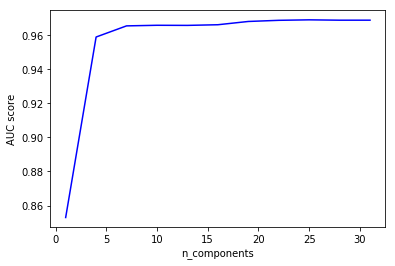

In [53]:
# plot the AUCs of the 11 different models. But since the baseline is very biased, comparing the AUC is not a good evaluation method.
from matplotlib.legend_handler import HandlerLine2D
line_auc = plt.plot(np.linspace(1,31,11, endpoint = True), auc_validation, 'b', label='Validation AUC')

plt.ylabel('AUC score')
plt.xlabel('n_components')
plt.show()

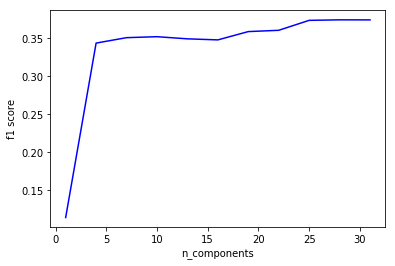

In [54]:
# plot the F1 scores of the 11 different models.
f = plt.figure()
plt.plot(np.linspace(1,31,11, endpoint = True), f1_validation, 'b', label='Validation f1')

plt.ylabel('f1 score')
plt.xlabel('n_components')
plt.show()

f.savefig('1.pdf')


## Apply PCA with 33 components logistic model to validation data to see the explained variance

In [38]:
pipeline_pca_33 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=33, inputCol='zfeatures', outputCol='loadings')
]).fit(pca_spark_df)

In [39]:
lr_pipeline_33 = Pipeline(stages=[pipeline_pca_34, lr]).fit(training_df)


In [40]:
explainedVariance = pipeline_pca_34.stages[-1].explainedVariance.toArray()

In [54]:
np.arange(1,34)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

<BarContainer object of 33 artists>

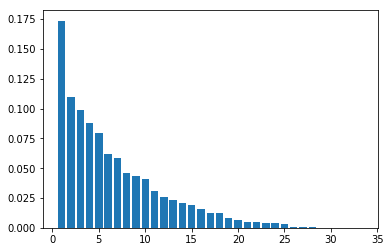

In [55]:
x = np.arange(1,34)
plt.bar(x,explainedVariance)

## Apply non-pca model to testing data

In [46]:
# test data's label list
original_test = testing_df.select('totalTransactionRevenue').toPandas()

In [47]:
# test data's prediction list
prediction_nopca = lr_pipeline_nopca.transform(testing_df)

In [ ]:

predicted_result = prediction_nopca.select('prediction').toPandas()
predicted_result = predicted_result.astype('int')
combine = pd.concat([predicted_result,original_test], axis = 1)
df_confusion_test = pd.crosstab(original_test['totalTransactionRevenue'],predicted_result['prediction'])
precision = df_confusion_test[1][1]/(df_confusion_test[1][1]+df_confusion_test[1][0])
recall = df_confusion_test[1][1]/(df_confusion_test[1][1] + df_confusion_test[0][1])
F1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
df_confusion_test

In [ ]:
F1

### Apply PCA with 25 components logistic model to testing data

In [64]:
pipeline_pca_25 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=25, inputCol='zfeatures', outputCol='loadings')
]).fit(pca_spark_df)

In [65]:
test_pipeline = Pipeline(stages=[pipeline_pca_25, lr]).fit(training_df)

In [66]:
prediction_pca_25 = test_pipeline.transform(testing_df)

In [67]:
AUC_testing_pca_25 = evaluator.evaluate(prediction_pca_25)

In [68]:
AUC_testing_pca_25

0.9688749506714862

In [69]:
baseline = 1-((testing_df.select('totalTransactionRevenue').toPandas().sum())/len(testing_df.select('totalTransactionRevenue').toPandas()))
baseline


totalTransactionRevenue    0.975386
dtype: float64

In [70]:

predicted_result_pca25 = prediction_pca_25.select('prediction').toPandas()
predicted_result_pca25 = predicted_result_pca25.astype('int')
combine_pca25 = pd.concat([predicted_result_pca25,original_test], axis = 1)
df_confusion_pca25 = pd.crosstab(original_test['totalTransactionRevenue'],predicted_result_pca25['prediction'])
precision_pca25 = df_confusion_pca25[1][1]/(df_confusion_pca25[1][1]+df_confusion_pca25[1][0])
recall_pca25 = df_confusion_pca25[1][1]/(df_confusion_pca25[1][1] + df_confusion_pca25[0][1])
F1_pca25 = 2 * (precision_pca25 * recall_pca25) / (precision_pca25 + recall_pca25)


In [71]:
df_confusion_pca25

prediction,0,1
totalTransactionRevenue,,
0,64806,5296
1,125,1644


In [72]:
F1_pca25

0.3775404753703066

## For Demo

In [50]:
# set the number of components
n_components = 3

In [51]:
## 

pipeline_pca_demo = Pipeline(stages=[
    feature.VectorAssembler(inputCols=pca_spark_df.columns[:-1],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=n_components, inputCol='zfeatures', outputCol='loadings')
]).fit(pca_spark_df)

In [52]:
lr_pipeline_demo = Pipeline(stages=[pipeline_pca_demo, lr]).fit(training_df)

In [53]:
#test_sample1,test_sample2 = testing_df.randomSplit([0.3,0.7], seed=0)


In [78]:
file = pd.read_csv('demo_logistic.csv',sep = ',')

In [83]:
test_demo = spark.createDataFrame(file)

In [84]:
test_sample_dm = test_demo# test_sample1 or test_sample2

In [85]:
## choose to fit validation or testing data
demo_df = test_sample_dm
#original_demo = demo_df.select('totalTransactionRevenue').toPandas()


In [86]:
prediction = lr_pipeline_demo.transform(demo_df).select('prediction').toPandas()
prediction = prediction.astype('int')

In [87]:
prediction

,prediction
0,0


In [56]:
def F1_score_demo(pipeline):
    prediction = pipeline.transform(demo_df).select('prediction').toPandas()
    prediction = prediction.astype('int')
    combine = pd.concat([prediction,original_demo], axis = 1)
    df_confusion = pd.crosstab(original_demo['totalTransactionRevenue'],prediction['prediction'])
    precision = df_confusion[1][1]/(df_confusion[1][1]+df_confusion[1][0])
    recall = df_confusion[1][1]/(df_confusion[1][1] + df_confusion[0][1])
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1


0.3429187634795111

In [60]:
def CM_demo(pipeline):
    prediction = pipeline.transform(demo_df).select('prediction').toPandas()
    prediction = prediction.astype('int')
    combine = pd.concat([prediction,original_demo], axis = 1)
    df_confusion = pd.crosstab(original_demo['totalTransactionRevenue'],prediction['prediction'])
    precision = df_confusion[1][1]/(df_confusion[1][1]+df_confusion[1][0])
    recall = df_confusion[1][1]/(df_confusion[1][1] + df_confusion[0][1])
    F1 = 2 * (precision * recall) / (precision + recall)
    return df_confusion


In [61]:
F1_score_demo(lr_pipeline_demo)

0.3429187634795111

In [62]:
CM_demo(lr_pipeline_demo)

prediction,0,1
totalTransactionRevenue,,
0,19147,1754
1,74,477
